### Time Series Modelling: Electricity Consumption



In [89]:
import pandas as pd 
import numpy as np 
import math
import matplotlib.pyplot as plt 
import seaborn as sns 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import acf,pacf 
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from pylab import rcParams
sns.set_style('darkgrid')
%matplotlib inline
rcParams['figure.figsize'] = 15,5 

In [86]:
#load dataset
df = pd.read_csv('/users/kunalramchurn/Desktop/Data/Electricity_consumption.csv',parse_dates=['DATE'])
df = df.rename({'IPG2211A2N':'Electricity_Consumption'},axis=1)
df.set_index('DATE',inplace=True)
df.head()

,Electricity_Consumption
DATE,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


In [87]:
#check for null values
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 397 entries, 1985-01-01 to 2018-01-01
Data columns (total 1 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Electricity_Consumption  397 non-null    float64
dtypes: float64(1)
memory usage: 6.2 KB


### Exploratory Data Analysis

#### Identifying trend patterns

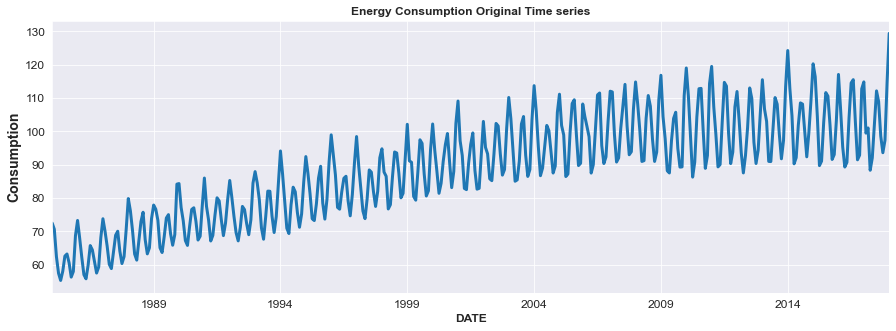

In [99]:
#use resample method with frequency to be on a monthly basis to identify the trend
plt.title('Energy Consumption Original Time series',weight='bold',fontsize=12);
df.Electricity_Consumption.fillna(method='bfill')
plt.ylabel("Consumption",fontsize=14,weight='bold')
plt.xlabel("Date",fontsize=12,weight='bold')
df.Electricity_Consumption.resample('M').mean().plot(linewidth=3,fontsize=12);

Observations:
- Increasing trend 
- Strong seasonality (evenly spaced peaks and troughs)
- plot exhibits non-stationary series

Based on a visual observation standpoint,the spikes appears to be roughly constant,that is,it is following the same seasonal pattern repeatedly, and the gradient changes appears to be the same for different years throughout the increasing trend, suggest that an Additive model will be appropriate for seasonal decomposition(discussed later).

### Applying Smoothing technique: Moving-Average method

We can visualize trend by using rolling method by setting the window size = 12 i.e at a monthly frequency, and use method chaining, by applying the mean, and dropping the Nan values that were created after the rolling function was applied.
The goal of this technique is to smooth the TS to be able to identify the trend by removing the seasonality and noise and help us to clearly identify the trend.
In short, the Moving Average is the average of a rolling window of defined width. 


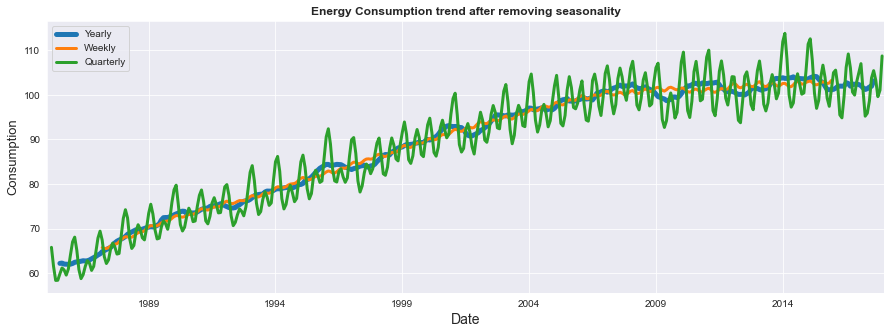

In [91]:
df.Electricity_Consumption.rolling(window=12,center=True).mean().dropna().plot(linewidth=5)
df.Electricity_Consumption.rolling(window=52,center=True).mean().dropna().plot(linewidth = 3);
df.Electricity_Consumption.rolling(window=4,center=True).mean().plot(linewidth=3);
plt.legend(['Yearly','Weekly','Quarterly']);
plt.xlabel('Date',fontsize =14)
plt.ylabel('Consumption',fontsize=13)
plt.title('Energy Consumption trend after removing seasonality',weight='bold');

Observation:

By setting the yearly(window-size =12) and the weekly(window_size=52) timeframe, the Moving average rolling window will successfully nullify the seasonal effect without causing any over-smoothing. The quarterly-average is a shorter window-size,therefore doesn't do such a great job in smoothing out the seasonality.

### Seasonality Decompostion Procedures

Seasonal decomposition of the Time Series components:

- Trend: exhibit upward trend Higher consumption over time, more digital products, improvement in technology 
- Seasonality: consumption higher at night(data points above 0) and lower during the day (data points below zero), pattern repeats itself
- Residual: random noise 

---------------------------------------------------

Model selection: Additive

Reason for applying the additive model to the decomposition procedures:

Based on a visual observation standpoint of the above plots,the spikes appears to be roughly constant,that is,it is following the same seasonal pattern repeatedly, and the gradient changes appears to be the same for different years throughout the increasing trend, suggest that an Additive model will be appropriate in order to draw useful insights.


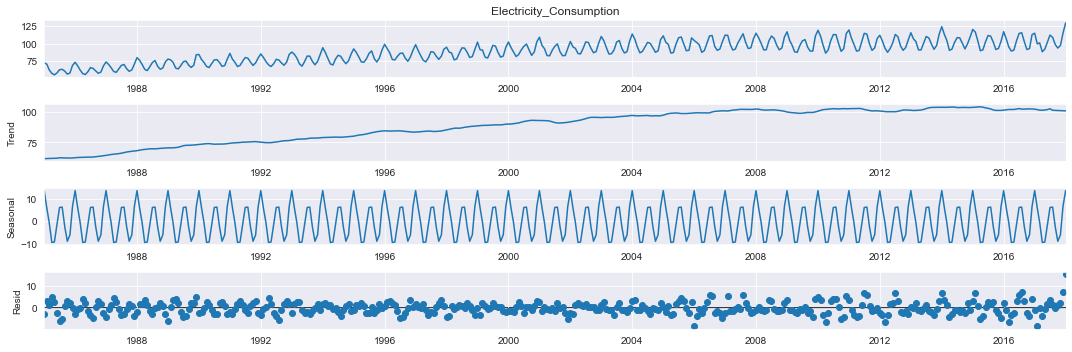

In [92]:
Decomp = seasonal_decompose(df.Electricity_Consumption,model='Additive',extrapolate_trend='freq');
Decomp.plot();
#used extrapolate as argument trend handles missing values if there are any.

### Test for stationarity

#### Stationarity concept definition:
- A Stationary time series data is one whose statistical properties(mean/standard deviation) remain constant over time.
- A Non-Stationary time series data is one whose statistical properties(mean/standard deviation) do not remain constant, and changes over time.

Recall: The visual observation so far,shows that the time series is non-stationary. In order to test for stationarity within the electricity consumption dataset, we will apply the Augmented Dickey-Fuller test to the dataset and interpret the results to confirm whether the time series data is stationary or not.

#### Augmented Dickey-Fuller(ADF) test 

The ADF test is a statistical test that can be used determine the presence of unit root in the series.
The presence of unit root(alpha = 1) means the time series is non-stationary.

In [33]:
def test_stationarity(timeseries):
    print ('Results of Augmented Dickey-Fuller (ADF) Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [34]:
test_stationarity(df.Electricity_Consumption)

Results of Augmented Dickey-Fuller (ADF) Test:
Test Statistic                  -2.256990
p-value                          0.186215
#Lags Used                      15.000000
Number of Observations Used    381.000000
Critical Value (1%)             -3.447631
Critical Value (5%)             -2.869156
Critical Value (10%)            -2.570827
dtype: float64


#### Result interpretation

Null Hypothesis: The series has a unit root (value of a =1)

Alternate Hypothesis: The series has no unit root.

Using $\alpha$ = 0.05, I will perform the following hypothesis test:
- $H_0$= not stationary / The series has a unit root (alpha =1)
- $H_A$ = stationary / The series has no unit root.(alpha= 0)


Interpret ADF test : test-statistic(-2.25) is greater than the critical value(-2.87) at statistical significance level of 0.05 and p-value > 0.05, therefore, we will reject Alternate Hypothesis($H_A$) and infer that time series is non-stationary. 

### White noise detection

A white noise time series is simply a sequence of uncorrelated random variables that are identically distributed. Unfortunately, for white noise, we cannot forecast future observations based on the past.

White noise exists
- If distribution is normal:  as mean = 0, and standard deviation = 1.
- If there are no auto-correlation (i.e autocorrelation at all lags =  0)

In [36]:
print('Mean : {}'.format(df.Electricity_Consumption.mean()))
print('Standard Deviation : {}'.format(df.Electricity_Consumption.std()))

Mean : 88.84721763224181
Standard Deviation : 15.387833664730909


<Figure size 720x360 with 0 Axes>

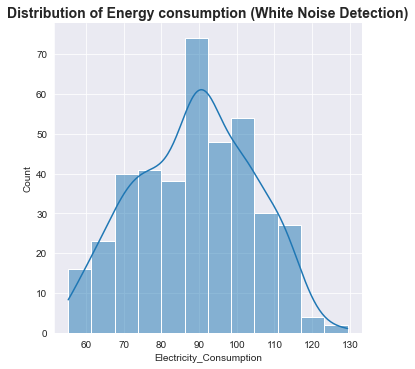

In [93]:
plt.figure(figsize=(10,5));
sns.displot(x=df.Electricity_Consumption,data=df,kde=True);
plt.title('Distribution of Energy consumption (White Noise Detection)',fontsize=14, weight= 'bold');

By using the Descriptive Summary Statistics + Distribution plot , the time series doesn't contain white noise as these conditions are met: 
- Mean/Level is non-zero and changes over time 
- Variance changes over time 
- Variable correlate with lag values(autocorrelation exists- discussed below)
- If visualized on a distribution plot/histogram, the shape follows a near-normal distribution but no definitive bell/Gaussian shape curve 

### Autocorrelation and Partial Autocorrelation Analysis

### Key Terms:

#### Autocorrelation 
Autocorrelation function is measure of the correlation between the original time series dataset with a lagged version of itself.

#### Partial Autocorrelation 
Partial autocorrelation function measures the correlation between the original time series with a lagged version of itself, but after removing the effect of any correlations due to the terms at shorter lags. For example, at lag 5, it will check the correlation but remove the effects already explained by lags 1 to 4.

#### Lags(denoted by term k)
Lags is a function that shifts a time series such that the “lagged” values are aligned with the actual time series.

The objective here is to: 
- To find optimal lag length: to be set to nlags= 15 as determined in the ADF test
- To optimize parameter of p,d,q to fit in the ARIMA model

### Method 1: Autocorrelation using statsmodel library

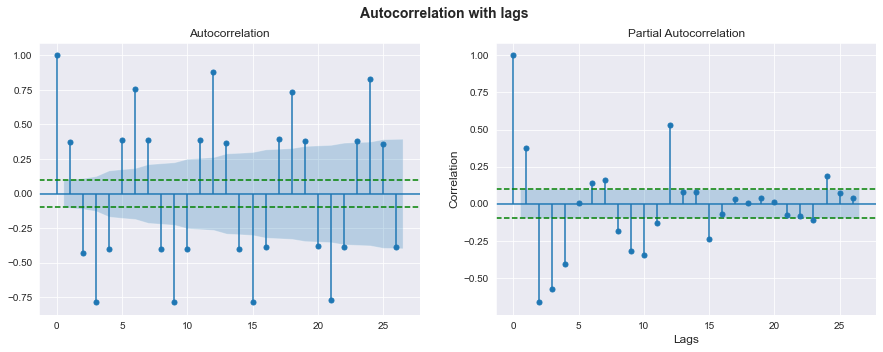

In [94]:
df_diff=df.diff().dropna()

fig,ax = plt.subplots(1,2,sharex=True,figsize=(15,5))
fig.suptitle('Autocorrelation with lags',weight='bold',fontsize=14)
for i in range(1,2):
    ax[0].axhline(y=1.96/np.sqrt(len(df_log_diff)),linestyle ="--",color ='green')
    ax[0].axhline(y=-1.96/np.sqrt(len(df_log_diff)),linestyle ="--",color ='green')
    ax[1].axhline(y=1.96/np.sqrt(len(df_log_diff)),linestyle ="--",color ='green')
    ax[1].axhline(y=-1.96/np.sqrt(len(df_log_diff)),linestyle ="--",color ='green')
ax[0]=plot_acf(df_diff,ax[0]);    
plt.ylabel('Correlation',fontsize=12)
plt.xlabel('Lags',fontsize=12)
ax[1]=plot_pacf(df_diff,ax[1]);

#### Observation from the correlogram above:

- The autocorrelation with lag zero always equals 1, because this represents the autocorrelation between each term and itself. 
- Lag 1 in both the pacf and acf function, is are the first to break out of the significance line.
- In the Pacf plot, we can see right after lag 1, then there is an exponential decrease in the lag values and in the acf function, there is a decrease up until lag 5. We will confirm this using the line plots 

### Method 2: Autocorrelation using statmodels with line-plots

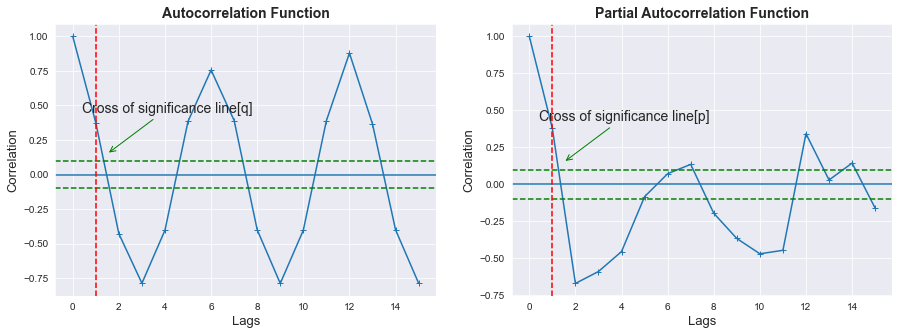

In [95]:
lag_acf = acf(df_diff,nlags=15);
lag_pacf = pacf(df_diff,nlags=15,method='ols');

plt.subplot(121);
plt.plot(lag_acf,marker='+')
plt.axhline(y=0)
plt.axhline(y=1.96/np.sqrt(len(df_log_diff)),linestyle ="--",color ='green')
plt.axhline(y=-1.96/np.sqrt(len(df_log_diff)),linestyle ="--",color ='green')
plt.axvline(x=1,linestyle='--',color='red')
plt.annotate('Cross of significance line[q]',xy=(1.5,0.15),fontsize = 14,
            xycoords='data',
            xytext=(60,45),
            textcoords='offset points',
            arrowprops=dict(arrowstyle='->',color='Green'), 
            horizontalalignment='center',  
            verticalalignment='center');
plt.title('Autocorrelation Function',weight='bold',fontsize=14);
plt.ylabel('Correlation',fontsize=13);
plt.xlabel('Lags',fontsize=13);

plt.subplot(122)
plt.plot(lag_pacf,marker='+')
plt.axhline(y=0)
plt.axhline(y=1.96/np.sqrt(len(df_log_diff)),linestyle ="--",color ='green')
plt.axhline(y=-1.96/np.sqrt(len(df_log_diff)),linestyle ="--",color ='green')
plt.axvline(x=1,linestyle='--',color='red')
plt.annotate('Cross of significance line[p]',xy=(1.5,0.15),fontsize = 14,
            xycoords='data',
            xytext=(60,45),
            textcoords='offset points',
            arrowprops=dict(arrowstyle='->',color='Green'), 
            horizontalalignment='center',  
            verticalalignment='center');
plt.title('Partial Autocorrelation Function',weight='bold',fontsize=14);
plt.ylabel('Correlation',fontsize=13);
plt.xlabel('Lags',fontsize=13);

In [61]:
#confirming the order term d(order of differencing)
from pmdarima.arima import ndiffs
ndiffs(df.Electricity_Consumption,alpha=0.05)

1

After differencing by 1 lag(also called first order differencing):

- p is obtained where the plot first cuts the upper confidence interval of the pacf.(annotated above)
- q is obtained where the plot first cuts the upper confidence interval of the acf.(annotated above)

Parameters to set for the ARIMA model:
- p: The pacf line crosses the significance line slightly after 1, so to approximate the model, we will pick p=2 
- q: We will keep q at 0 for this analysis.
- d: order of the differencing should be set to 1 as confirmed by pmdarima package.

### Differencing technique - Transforming the original time series to Stationary data

In order to fit a dataset to a Time Series Model and run the forecasting algorithm, data points have to be stationary form.

We will use the differencing method to transform the dataset.

- Goal: Look at the differencing between successive time points,remove the trend and seasonality from time series.
- Method: first-order differencing
- The mean and std deviation are centered at 0.
- This same diffencing method will be applied to the ARIMA model below.

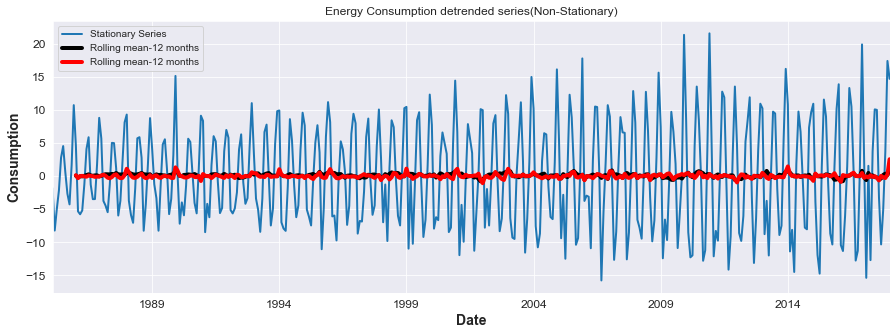

In [96]:
df.Electricity_Consumption.diff().dropna().plot(linewidth =2,title='Energy Consumption detrended series(Non-Stationary)',fontsize=12);
df.Electricity_Consumption.rolling(12).mean().diff().dropna().plot(linewidth=4,color='black')
df.Electricity_Consumption.rolling(12).std().diff().dropna().plot(linewidth=4,color = 'red')
plt.legend(['Stationary Series','Rolling mean-12 months','Rolling mean-12 months']);
plt.xlabel('Date',fontsize=14,weight= 'bold');
plt.ylabel('Consumption',fontsize=14,weight='bold');

In [21]:
df['detrended'] =df.Electricity_Consumption.diff().dropna()
print('Mean of detrended series: {}'.format(df['detrended'].mean()))

Mean of detrended series: 0.14368585858585856


As confirmed by first-order differencing, the mean/standard deviation is close to zero, and the series is centered towards the zero line as well suggesting that the differencing should be applied succesfully to the model. There is no need to set differencing a second time, as this could lead to overdifferencing and may not be optimal for the model.

### Time-Series Modelling using the ARIMA model

#### Breakdown of ARIMA model components:

The AutoRegressive Integrated Moving Average (ARIMA) Model describes a model that can be trained on a given time series based on its own past values,i.e using its own lags and the lagged forecasted errors as parameters in its equation, and the same equation can then be used to forecast future values.

Syntax: ARIMA(df.values, order=(p,d,q))

-----------------------------------------------
Tuning parameters before plugging into the model:

- p is the order of the Auto Regressive(AR) term. It refers to the number of lags observations to be used as predictors. 

- d is the order of the Integrated(I) term Makes the TS stationary. The number of times that the raw observations are differenced, i.e the degree of differencing.

- q is the order of the Moving Average(MA) term. It refers to the size/of the moving average window/ number of laggesd forecast errors that should go into the Arima model.

The ARIMA order parameters were determined from the Autocorrelation/Partial Autocorrelation analysis explained above.
- p: 2
- d: 1
- q: 0

In [15]:
model = ARIMA(df.diff().dropna().values,order=(2,1,0))
result_AR = model.fit()
print(result_AR.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  395
Model:                 ARIMA(2, 1, 0)   Log Likelihood               -1378.186
Method:                       css-mle   S.D. of innovations              7.923
Date:                Fri, 15 Jan 2021   AIC                           2764.373
Time:                        14:21:29   BIC                           2780.288
Sample:                             1   HQIC                          2770.679
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0317      0.337      0.094      0.925      -0.629       0.692
ar.L1.D.y      0.1957      0.047      4.202      0.000       0.104       0.287
ar.L2.D.y     -0.3800      0.047     -8.156      0.0

#### Model Summary Interpretation

- ar.L1 refers to the autoregressive term with the lag of 1 
- ar.L2 represents the same, but with the lag of 2.

The autoregressive term has a p-value( P>|z|) that is less than the significance level of 0.05. You can conclude that the coefficient for the autoregressive term is statistically significant. Therefore, the model was ran successfully and there is no need to refit the model or change its parameters.

### Model Evaluation

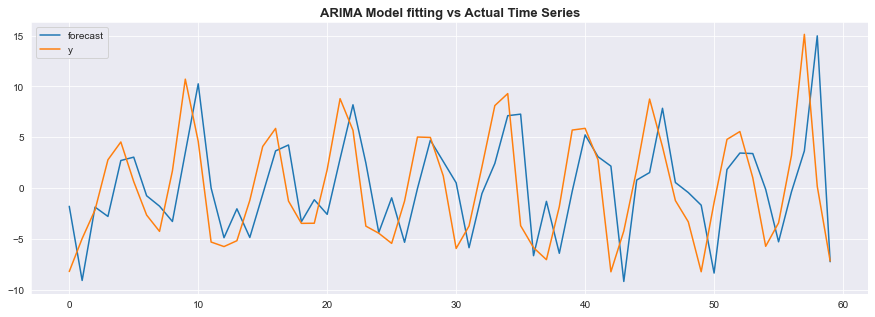

In [97]:
result_AR.plot_predict(start=1,end=60,dynamic=False);
plt.title('ARIMA Model fitting vs Actual Time Series',fontsize=13,weight='bold');

Observation: As the forecasted model (Orange line) follows pretty closely to the actual time series(blue line), we can say that the ARIMA model has been fitted well.

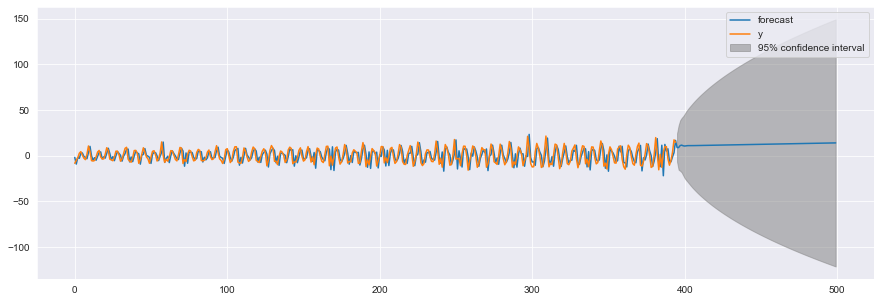

In [98]:
result_AR.plot_predict(1,500)
x=result_AR.forecast(steps=200)